In [399]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [400]:
# import os
# os.listdir()

In [401]:
imgs = torch.load("linear.pt")

In [404]:
imgs = imgs.squeeze(1)

In [405]:
rotated_90 = torch.rot90(imgs, k=1, dims=[1, 2])
rotated_180 = torch.rot90(imgs, k=2, dims=[1, 2])
rotated_270 = torch.rot90(imgs, k=3, dims=[1, 2])

# Concatenate the original tensor with the rotated ones
imgs = torch.cat((imgs, rotated_90, rotated_180, rotated_270), dim=0)


imgs.shape

torch.Size([400000, 22, 22])

In [406]:
imgs[0].max()

tensor(1.)

In [407]:
# plt.imshow(sample_imgs[3])

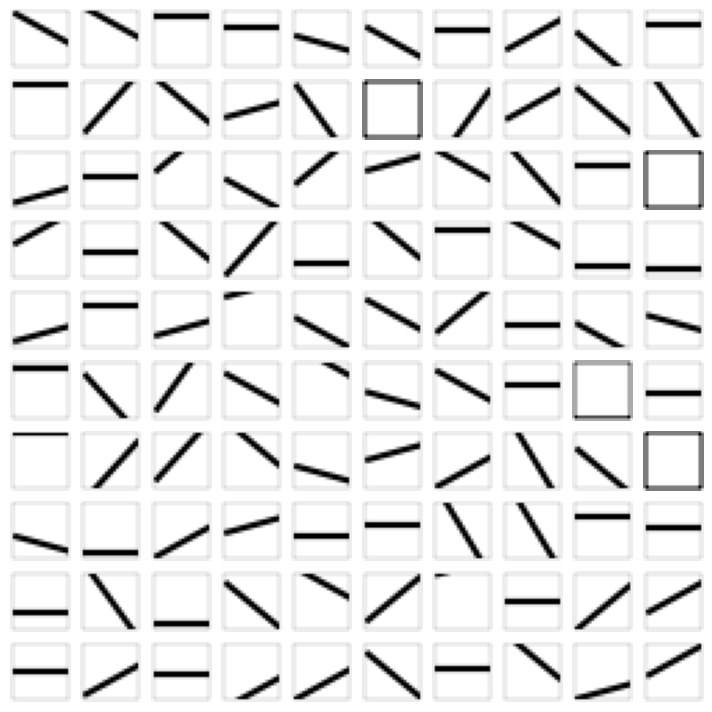

In [408]:
# num_samples = 25
sample_imgs = [i for i in imgs]

fig = plt.figure(figsize=(9, 9))
grid = ImageGrid(fig, 111, nrows_ncols=(10,10), axes_pad=0.1)

for ax, im in zip(grid, sample_imgs):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
plt.show()

In [409]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

mps


In [410]:
IMG_WIDTH = 22
IMG_HEIGHT =22
IMG_SIZE = IMG_WIDTH * IMG_HEIGHT

In [592]:
dataset = TensorDataset(imgs)
batch_size =  256# 128 works really well
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [593]:
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.encode = nn.Sequential(
#             nn.Linear(IMG_SIZE, 256),
#             nn.LeakyReLU(0.2),
#             nn.Linear(256, 64),
#             nn.LeakyReLU(0.2),
#         )
        
#         self.log_var_layer = nn.Sequential(
#             nn.Linear(64, 2)
#         )
        
#         self.mean_layer = nn.Sequential(
#             nn.Linear(64, 2)
#         )
        
#         self.decode = nn.Sequential(
#             nn.Linear(2, 64),
#             nn.LeakyReLU(0.2),
#             nn.Linear(64, 256),
#             nn.LeakyReLU(0.2),
#             nn.Linear(256, IMG_SIZE),
#             nn.Sigmoid()
#         )
        
#     def get_latent(self, encoded_x):
#         log_var = self.log_var_layer(encoded_x)
#         mean = self.log_var_layer(encoded_x)
        
#         epsilon = torch.randn_like(log_var).to(device)
        
#         z = mean + log_var * epsilon
#         return z, mean, log_var
    
#     def forward(self, x):
#         x = x.view(-1, IMG_SIZE)
#         encoded = self.encode(x)
#         z, mean, logvar = self.get_latent(encoded)
#         logits = self.decode(z)
        
#         return logits, mean, logvar

# claude opus alt
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.encode = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(8 * 6 *6, 64),
            nn.LeakyReLU(0.2),
        )
        self.log_var_layer = nn.Sequential(
            nn.Linear(64, 2)
        )
        self.mean_layer = nn.Sequential(
            nn.Linear(64, 2)
        )
        self.decode = nn.Sequential(
            nn.Linear(2, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 8 * 6 * 6),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (8, 6, 6)),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def get_latent(self, encoded_x):
        log_var = self.log_var_layer(encoded_x)
        mean = self.log_var_layer(encoded_x)
        epsilon = torch.randn_like(log_var).to(device)
        z = mean + log_var * epsilon
        return z, mean, log_var

    def forward(self, x):
        x = x.view(-1, 1, IMG_WIDTH, IMG_HEIGHT)
#         print(x.shape)
        encoded = self.encode(x)
        z, mean, logvar = self.get_latent(encoded)
#         print(z.shape)
        logits = self.decode(z)
#         print(logits.shape)
        logits = logits.view(-1, IMG_SIZE)
        return logits, mean, logvar

In [594]:
model = NeuralNetwork().to(device)

In [595]:
print(model)

NeuralNetwork(
  (encode): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=288, out_features=64, bias=True)
    (6): LeakyReLU(negative_slope=0.2)
  )
  (log_var_layer): Sequential(
    (0): Linear(in_features=64, out_features=2, bias=True)
  )
  (mean_layer): Sequential(
    (0): Linear(in_features=64, out_features=2, bias=True)
  )
  (decode): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Unflatten(dim=1, unflattened_size=(8, 6, 6))
    (5): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.2)
    (7

In [608]:
mse = nn.MSELoss()
def loss_and_regularization(pred, target, mean, logvar):
#     pred_loss = torch.sum((pred - target)**2)
    pred_loss = mse(pred, target)

#     regularization_loss = -0.0005 * torch.sum(1 + logvar - mean**2- torch.exp(logvar))
    regularization_loss = -0.0005 * torch.sum(1+ logvar - mean.pow(2) - logvar.exp())


    return pred_loss + regularization_loss



In [597]:
loss_fn = loss_and_regularization
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [598]:
def train(data, model, loss_fn, optimizer, id):
    size = len(data)
    model.train()
    loss_total = 0

    for x in dataloader:
        x = x[0].to(device)
        
        pred, mean, logvar = model(x)
        loss = loss_fn(pred, x.view(-1, IMG_SIZE), mean, logvar)
        loss_total += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    if (id % 10 == 0):
        print(loss_total)
    

In [599]:
train(imgs, model, loss_fn, optimizer, 1)

In [600]:
for i in range(1000):
    train(imgs, model, loss_fn, optimizer, i)

103.47730061411858
92.35906234383583
86.97214128449559
85.40799950808287
84.58198457211256
83.70478009805083
83.38036311417818
83.0917516425252
82.7549273185432
82.45369675382972
82.23951194062829
82.12032847478986
82.20558068528771
82.21385869756341
81.9594190530479
81.88311860710382
81.90093300119042
81.90668715536594
81.8224571608007
81.72206379845738


KeyboardInterrupt: 

In [601]:
to_print = []

for i in range(50):
    pred, _, _ = model(imgs[i].to(device))
    pred = pred.view(IMG_HEIGHT, IMG_WIDTH)
    to_print += [imgs[i], pred.to("cpu").detach().numpy()]

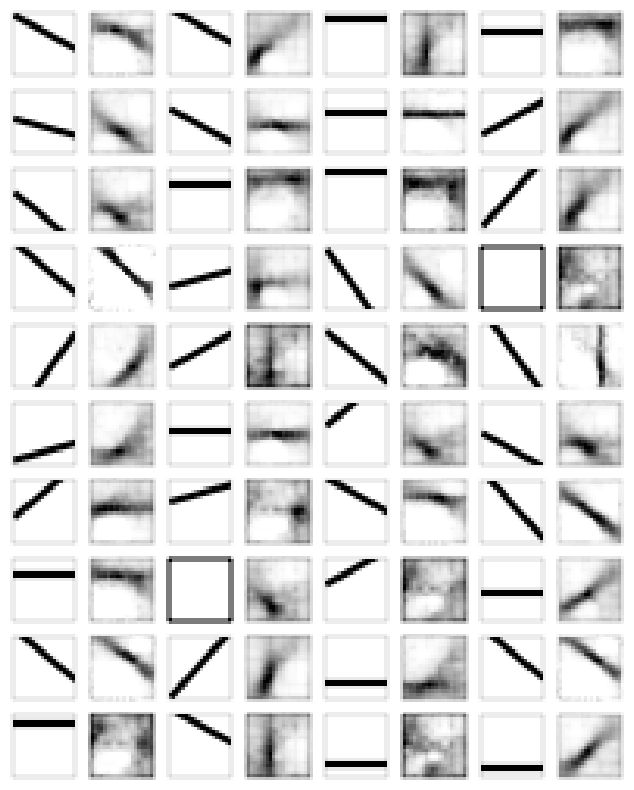

In [602]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(10,8), axes_pad=0.1)

for ax, im in zip(grid, to_print):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
plt.show()

In [603]:
inputs = [
    torch.tensor([[2.0, 0.0]]),
    torch.tensor([[0.0, 2.0]]),
    torch.tensor([[2.0, 2.0]]),
    torch.tensor([[-2.0, 0]]),
    torch.tensor([[-2.0, -2.0]]),
    torch.tensor([[0.0, -2.0]]),
    torch.tensor([[2.0, -2.0]]),
    torch.tensor([[-2.0, 2.0]]),
]

torch.Size([1, 2])
torch.Size([22, 22])
torch.Size([1, 2])
torch.Size([22, 22])
torch.Size([1, 2])
torch.Size([22, 22])
torch.Size([1, 2])
torch.Size([22, 22])
torch.Size([1, 2])
torch.Size([22, 22])
torch.Size([1, 2])
torch.Size([22, 22])
torch.Size([1, 2])
torch.Size([22, 22])
torch.Size([1, 2])
torch.Size([22, 22])


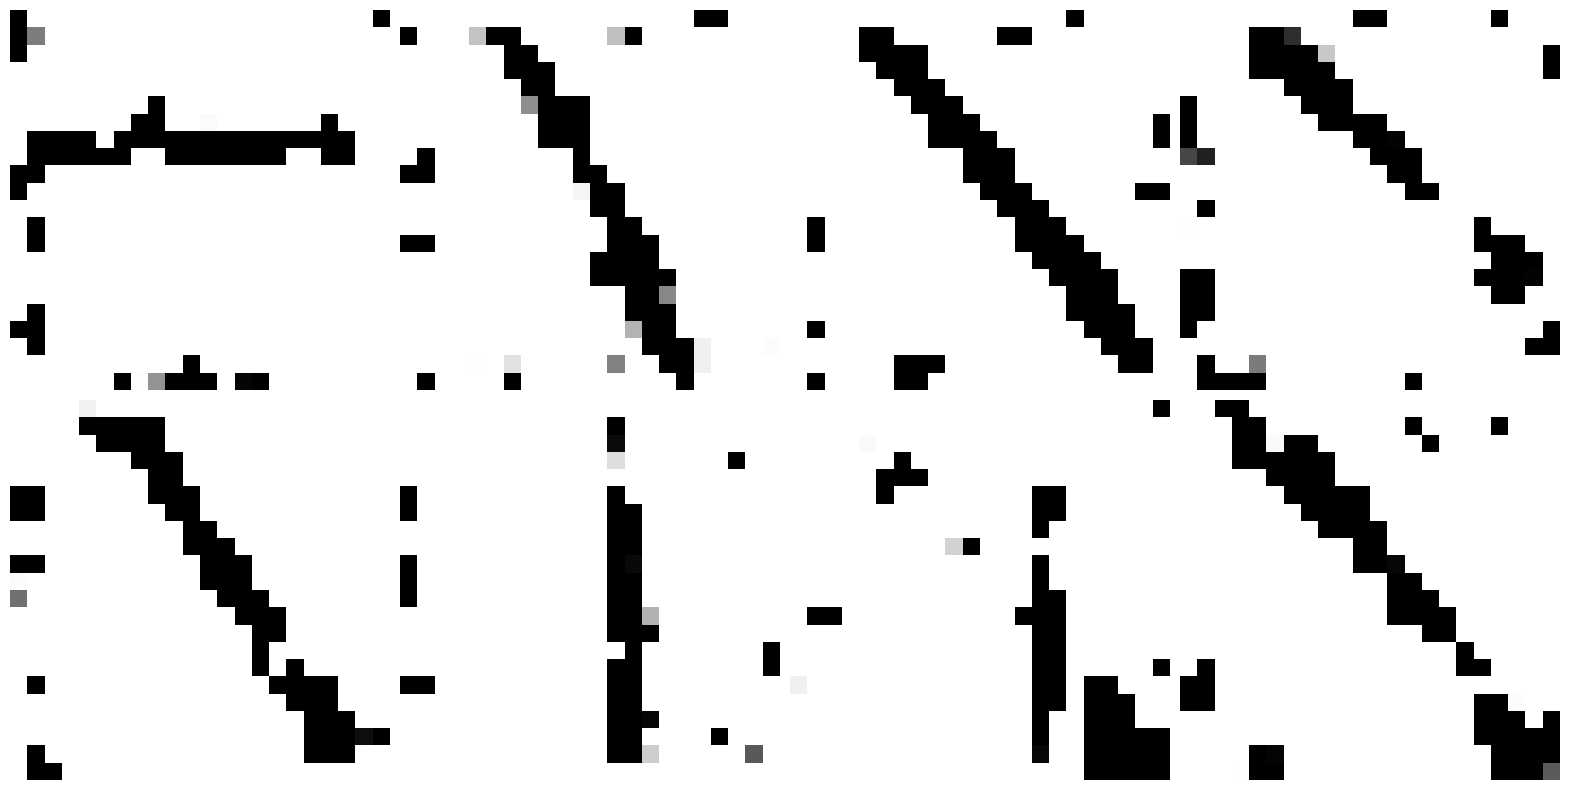

In [604]:
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 4), axes_pad=0.1)

for ax, im in zip(grid, inputs):
    print(im.shape)
    
    pred = model.decode(im.to(device))
    pred = pred.view(1, IMG_HEIGHT,IMG_WIDTH).squeeze()
    print(pred.shape)
    ax.imshow(pred.to("cpu").detach().numpy(), cmap='gray')
    ax.axis('off')
plt.show()

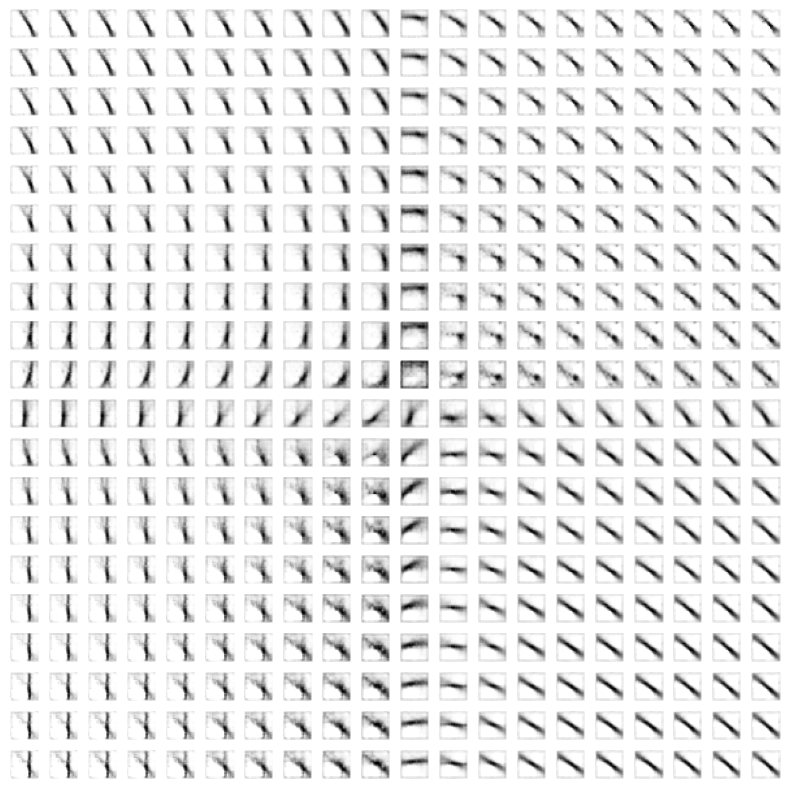

In [607]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(20,20), axes_pad=0.1)

to_graph = []
m = 0.001
for i in np.arange(-10 *m , 10.0 * m , 1 * m ):
    for j in np.arange(-10 * m , 10.0 * m, 1* m ):
        latent = torch.tensor([[i,j]]).float()
        pred = model.decode(latent.to(device))
        pred = pred.view(IMG_HEIGHT, IMG_WIDTH).detach().cpu().numpy()
        to_graph.append(pred)



for ax, im in zip(grid, to_graph):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
plt.show()

In [104]:
import numpy as np

In [ ]:
plot_latent_space(model)